In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import torch
 
from utils_pdhg import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(0)
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle  + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2
\end{array} 
$$



## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right )
\end{aligned}
$$


In [3]:
for (m, n) in [(30, 60), (60, 30)]:
    for _ in range(5):
        # NumPy data for CVXPY reference
        A_np = np.random.randn(m, n)
        B_np = np.random.randn(m, n)
        Y0_np = np.random.randn(n, n)
        G1_np = B_np @ Y0_np.T
        G2_np = A_np @ Y0_np

        beta = 0.5
        Z0_1, Z0_2, f_star, Y_star = cvxpy_AB(G1_np, G2_np, A_np, B_np, beta)

        # Torch tensors
        A2 = torch.from_numpy(A_np).to(torch.float32).to(device)
        A1 = torch.from_numpy(B_np).to(torch.float32).to(device)
        G1 = torch.from_numpy(G1_np).to(torch.float32).to(device)
        G2 = torch.from_numpy(G2_np).to(torch.float32).to(device)

        # Torch prox for h* (uses prox_l1 from pdhg.py)
        prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
        h_conj = lambda y: beta * torch.abs(y).sum()

        # Run torch PDHG
        Z_t, residuals, _, Y_t = pdhg_kq_attn_layer(
            prox_h_conj, A2=A2, A1=A1, G1=G1, G2=G2,
            max_iter=10000, eps_abs=1e-8, eps_rel=1e-8, mu=0,
            stopping=False, h_conj=h_conj, beta=beta, pd_residuals=pd_residuals_max_ball,
            diag_scaling=False, equilibration=False, reflected_halpern=False, enable_restart=False)

        Z1_t, Z2_t = Z_t[:m, :], Z_t[m:, :]

        # Back to NumPy for comparison
        Z1 = Z1_t.cpu().numpy()
        Z2 = Z2_t.cpu().numpy()

        assert np.allclose(
            np.trace(Z0_1.T @ G1_np + Z0_2.T @ G2_np),
            np.trace(Z1.T @ G1_np + Z2.T @ G2_np),
            atol=1e-3,
            rtol=1e-3,
        )
        assert np.max(np.abs(Z1.T @ B_np + A_np.T @ Z2)) <= beta + 1e-2 and np.max(
            np.abs(Z0_1.T @ B_np + A_np.T @ Z0_2)
        ) <= beta + 1e-2
print("PASSED")

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


PASSED


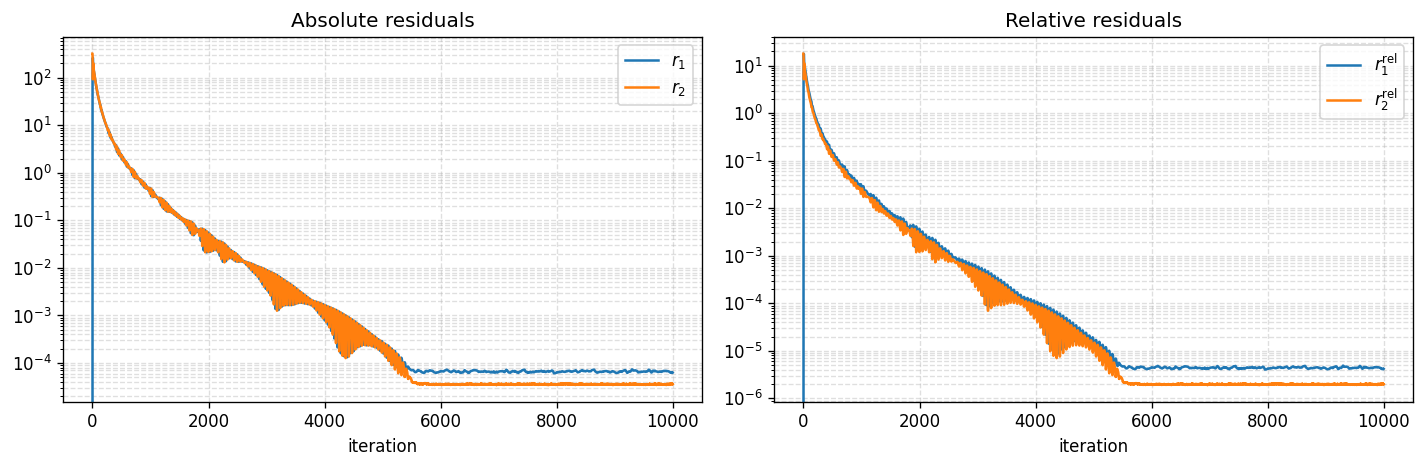

In [4]:
plot_residuals(residuals)

## Dual feasibility checks

In [5]:
for (m, n) in [(30, 60), (60, 30), (60, 60)]:
    print(f"{m}x{n}")
    for _ in range(5):
        A_np = np.random.randn(m, n)
        B_np = np.random.randn(m, n)
        Y0_np = np.random.randn(n, n)
        G1_np = B_np @ Y0_np.T
        G2_np = A_np @ Y0_np

        A = torch.from_numpy(A_np).to(torch.float64)
        B = torch.from_numpy(B_np).to(torch.float64)
        G1 = torch.from_numpy(G1_np).to(torch.float64)
        G2 = torch.from_numpy(G2_np).to(torch.float64)

        _, res1 = Y_dual_feasible(A1=B, A2=A, G1=G1, G2=G2, method="lsqr", maxit=1000) 
        _, res2 = Y_dual_feasible(A1=B.to(torch.float32), A2=A.to(torch.float32), G1=G1.to(torch.float32), G2=G2.to(torch.float32), method="lsqr", maxit=1000)
        print("residual:", res1, "residual (float32):", res2)

30x60
residual: {'res_C': 7.395190682077207e-08, 'res': 7.857218390154141e-07, 'iter': 44} residual (float32): {'res_C': 8.67251343284418e-08, 'res': 9.214343891584895e-07, 'iter': 44}
residual: {'res_C': 7.89451851648278e-08, 'res': 8.905994408309088e-07, 'iter': 48} residual (float32): {'res_C': 8.990352251990397e-08, 'res': 1.0142230059301848e-06, 'iter': 48}
residual: {'res_C': 9.08076283236199e-08, 'res': 9.86124145635685e-07, 'iter': 44} residual (float32): {'res_C': 7.91862725193172e-08, 'res': 8.599221522105521e-07, 'iter': 45}
residual: {'res_C': 6.563356741695694e-08, 'res': 7.320625900495421e-07, 'iter': 41} residual (float32): {'res_C': 8.143012289434794e-08, 'res': 9.082539444495026e-07, 'iter': 41}
residual: {'res_C': 6.931675809960154e-08, 'res': 7.456037308828981e-07, 'iter': 43} residual (float32): {'res_C': 8.404861929436909e-08, 'res': 9.040665812792113e-07, 'iter': 43}
60x30
residual: {'res_C': 6.133534039362924e-08, 'res': 7.455486354956862e-07, 'iter': 31} residua

In [7]:
for (m, n) in [(500, 500)]: 
    # NumPy data for CVXPY reference
    A_np = np.random.randn(m, n)
    B_np = np.random.randn(m, n)
    Y0_np = np.random.randn(n, n)
    G1_np = B_np @ Y0_np.T
    G2_np = A_np @ Y0_np

    beta = 0.5 
    # Torch tensors
    A = torch.from_numpy(A_np).to(torch.float32).to(device)
    B = torch.from_numpy(B_np).to(torch.float32).to(device)
    G1 = torch.from_numpy(G1_np).to(torch.float32).to(device)
    G2 = torch.from_numpy(G2_np).to(torch.float32).to(device)

    Y0, dual_res = Y_dual_feasible(A1=B, A2=A, G1=G1, G2=G2, method="lsqr", maxit=1000) 
    print(f"{dual_res=}")

    # Torch prox for h* (uses prox_l1 from pdhg.py)
    prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
    h_conj = lambda y: beta * torch.abs(y).sum()

    # Run torch PDHG
    Z_t, residuals, _, Y_t = pdhg_kq_attn_layer(
        prox_h_conj, A2=A, A1=B, G1=G1, G2=G2,
        max_iter=10000, eps_abs=1e-8, eps_rel=1e-8, mu=0, Y0=Y0,
        stopping=False, h_conj=h_conj, beta=beta, pd_residuals=pd_residuals_max_ball,
        diag_scaling=False, equilibration=False, reflected_halpern=False, enable_restart=False)

    Z1_t, Z2_t = Z_t[:m, :], Z_t[m:, :]

    # Back to NumPy for comparison
    Z1 = Z1_t.cpu().numpy()
    Z2 = Z2_t.cpu().numpy()

dual_res={'res_C': 1.1739866715051077e-07, 'res': 4.5469746630725856e-06, 'iter': 1000}


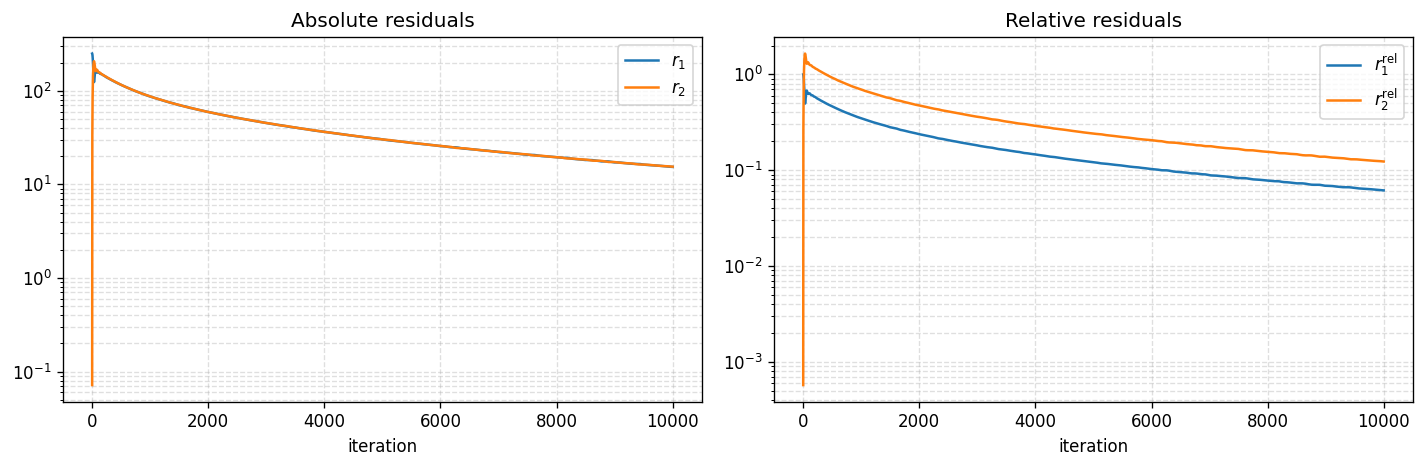

In [8]:
plot_residuals(residuals)

In [9]:
max(residuals["r1_rel"][:50]), max(residuals["r2_rel"][:50]), min(residuals["r1_rel"][:50]), min(residuals["r2_rel"][:50])

(1.0, 1.6487374516177462, 0.49580093383789064, 0.0005706750911886623)